pytorch チュートリアル  
[公式doc](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py) 
[参考](https://qiita.com/kenchon/items/1791c4b75a93ad2935a3)
- Training a classifier

# 分類器の学習

このチュートリアルでは，CIFAR10データセットを使います。

CIFAR10には，下記の10クラスがあります：
`airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`

CIFAR10に含まれる画像サイズは 3x32x32 つまり，3つのカラーチャンネルを持つ32x32のピクセルからなります。

# 画像分類器の学習
CIFAR10を用いた画像分類器の訓練のために，下記の工程を順に行います。

1. 学習用画像とテスト用画像を読み込み，正規化する。このとき，torchvisionを使う。
2. 畳み込みニューラルネットワークを定義する。
3. 損失関数を定義する。
4. 学習用画像を用いて学習する。
5. テスト用画像を用いてテストする。


## 1. CIFAR10の読み込みと正規化
torchvisionを使えば，CIFAR10の読み込みはとても簡単にできます。

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision に含まれるデータセットはPILImageで，`[0,1][0,1]`のレンジを持ちます。これを，`[−1,1][−1,1]`に正規化したテンソルに変換します。

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5)
     , (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


データセットに含まれている画像がどんなものか見てみる

dog truck  ship  frog


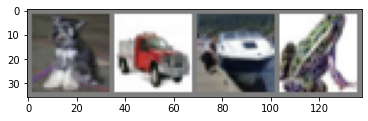

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. 畳み込みニューラルネットワークを定義する
１つ前のチュートリアルで示したニューラルネットワークのコードをコピーしてきて，画像のチャンネルを3に変更します。前回のものは白黒画像だったので，チャンネルは１でした。変更後のモデルは次のようになります。

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # チャンネルを1に変更．(nSamples x nChannels x Height x Width)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 損失関数の定義と最適化
損失関数として分類学習のクロスエントロピーを，最適化手法として，確率的勾配降下法(SGD)+モーメンタム法を使います．

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # クロスエントロピー
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SDG: 確率的勾配降下法

## 4. ネットワークを学習させる
ここからが楽しいところですね。学習は，ネットワークへの入力と最適化を学習データの数だけループさせることで行います。

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.864
[1,  6000] loss: 1.676
[1,  8000] loss: 1.577
[1, 10000] loss: 1.509
[1, 12000] loss: 1.461
[2,  2000] loss: 1.393
[2,  4000] loss: 1.385
[2,  6000] loss: 1.346
[2,  8000] loss: 1.323
[2, 10000] loss: 1.324
[2, 12000] loss: 1.273
Finished Training


## 5. テストデータでネットワークをテストする
１つ前の出力を見たらわかりますが，学習用データセットの２周分でネットワークを学習させました。しかし，ネットワークがちゃんと学習したかどうか確認する必要があります。

つまり，学習したニューラルネットワークの出力（つまり予測クラス）が，入力画像のクラスラベルと一致しているかを確認すればよいですね。もし，予測がうまくいっていたら，正しく予測できたリストにサンプルを追加します。

それでは，具体的にどうするか見ていきます。まず，テストデータの一部とそのクラスラベルを表示してみましょう：

GroundTruth:    cat  ship  ship plane


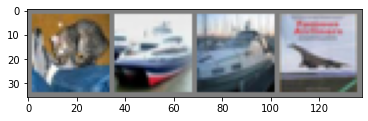

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

それでは，学習したニューラルネットワークがどのように上記の画像を予測するのでしょうか。

In [14]:
outputs = net(Variable(images))


出力は10クラスのどれかです。ニューラルネットワークは，10クラスのどれが尤もらしいかを数字で表現します。数字が高いほど，そのクラスに属している可能性が高いと判断するということです。ここで，上記の４つの各々の画像に対して，一番高い数値を与えたクラスを出力してみます。

In [15]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


それでは，全てのテストデータに対して，どのような予測結果を与えるかを見てみましょう。

In [16]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


この結果は，ランダムにクラスを選んだ場合（確率0.1）よりも良い結果ですね！これは，ネットワークがランダムに画像にクラスを割り当ててるのではなく，何かを学習したうえでラベルを予測していると言ってよいでしょう。

では次に，どのクラスがどれだけ良く予測できたかを見てみましょう。

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 75 %
Accuracy of  bird : 47 %
Accuracy of   cat : 40 %
Accuracy of  deer : 57 %
Accuracy of   dog : 34 %
Accuracy of  frog : 50 %
Accuracy of horse : 52 %
Accuracy of  ship : 65 %
Accuracy of truck : 35 %
